In [1]:
from collections import deque
from itertools import chain
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm

from q_net import QNet
from common_components import env, MAX_STEPS


# MAX_STEPS = 500  # you may want to override MAX_STEPS from common_components


n_state_params = env.observation_space.shape[0]
n_actions = env.action_space.n

In [2]:
def plot_rews_lens(*, rews, lens, losses, window_n=10, loss_log_scale=False):
    """Plots episode rewards, lengths and losses averaged with sliding mean window size window_n."""
    fig, axs = plt.subplots(1, 3)
    fig.set_size_inches(25, 5)

    lens_ = np.convolve(lens, np.ones(window_n) / window_n, mode='valid')
    rews_ = np.convolve(rews, np.ones(window_n) / window_n, mode='valid')
    losses_ = np.convolve(losses, np.ones(window_n) / window_n, mode='valid')

    ax = axs[0]
    ax.plot(rews_, c='darkred')
    ax.set_title('Mean episode rewards')

    ax = axs[1]
    ax.plot(lens_, c='navy')
    ax.set_title('Mean episode lengthes')

    ax = axs[2]
    ax.plot(losses_, c='darkgreen')
    ax.set_title('Mean episode losses')
    if loss_log_scale:
        ax.set_yscale('log')

    # for ax in axs:
    #     ax.set_xticks([])
    plt.tight_layout();

In [309]:
# def softmax(x: torch.Tensor, tau: float = 1.) -> torch.Tensor:
#     """'Heated' with 'temperature' tau softmax function"""
#     res = torch.exp(x / tau) / (torch.sum(torch.exp(x / tau)))
#     if res.min() <= 0:
#         res += (-res.min() + 1e-9)
#     if res.max() >= 1:
#         res /= (res.max() + 1e-9)
#     return res

---
# Reinforce (discrete)

## Model & Optimizer

In [3]:
policy = QNet()  # use the same net structure as for Q-net learning
optimizer = torch.optim.Adam(policy.parameters(), lr=0.003)

In [ ]:
# Current LR

for pg in optimizer.param_groups:
    print(pg['lr'])

0.0001


In [452]:
# Change LR

for pg in optimizer.param_groups:
    pg['lr'] = 0.001

## Training

In [4]:
losses = []
ep_lens = []
ep_rews = []

In [ ]:
EPOCHS = 100000
GAMMA = 0.99


pbar = tqdm(range(EPOCHS))
for epoch in pbar:

    ## RUN TRAJECTORY
    states = []
    actions = []
    rewards = []
    log_probs = []
    
    state = env.reset()
    for step in range(MAX_STEPS):
        prob_d = torch.distributions.Categorical(logits=policy(torch.tensor(state)))

        action = prob_d.sample()  # torch.multinomial(F.softmax(policy(torch.tensor(state)), dim=0), num_samples=1)
        log_prob = prob_d.log_prob(action)  # F.log_softmax(policy(torch.tensor(state)), dim=0)[action]
        # log_prob = policy(torch.tensor(state))[action]
        action = action.item()

        new_state, reward, is_done, info = env.step(action)
        
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        log_probs.append(log_prob)

        if is_done:
            ep_lens.append(step + 1)
            ep_rews.append(sum(rewards))
            break

        state = new_state

    ## GET GAINS
    gains = deque()
    gain = 0
    for n, reward in enumerate(reversed(rewards)):
        gain = reward + gain * GAMMA
        gains.appendleft(gain)
    
    ## UPDATE POLICY
    log_probs = torch.stack(log_probs)
    loss = torch.sum(-log_probs * torch.tensor(gains))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())

    ## MONITORING
    pbar.set_postfix({'ep_rew': str(sum(rewards)), 'ep_len':str(step + 1), 'loss': loss.item()})

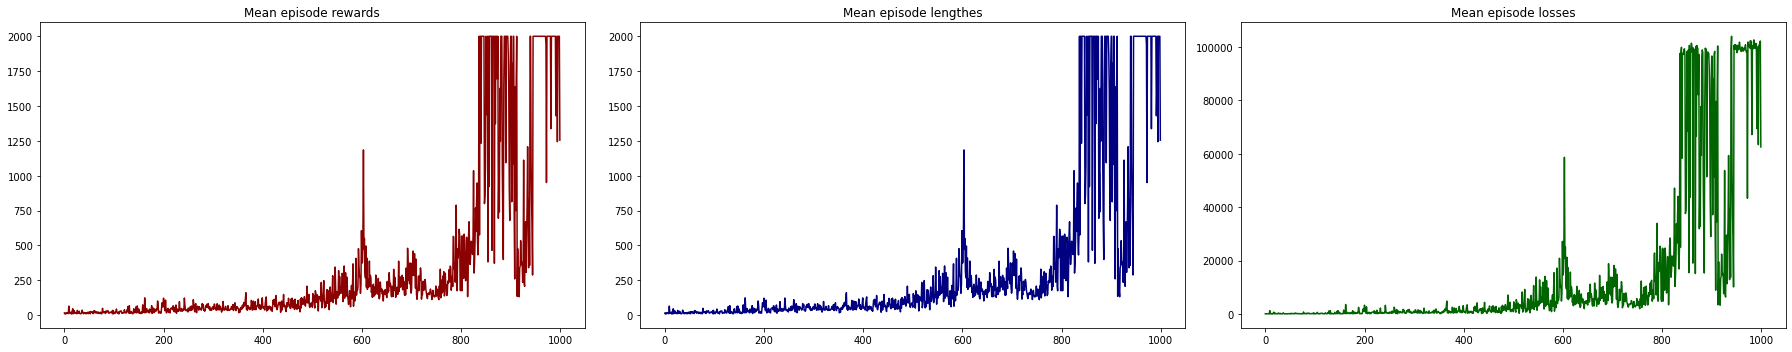

In [495]:
plot_rews_lens(rews=ep_rews, lens=ep_lens, losses=losses, window_n=1, loss_log_scale=False)

In [496]:
## SAVE

torch.save(policy.state_dict(), 'policy_weights.pth')